In [17]:
import numpy as np
import pandas as pd
from scipy import stats

import networkx as nx

import dowhy
from dowhy import CausalModel

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
dowhy.__version__

'0.12'

# Decision-Making Errors (Pt 1)

This is an example demonstrating how **untackled confounding** can lead to dashboards that, if interpreted without caution, may result in **poor decisions**.

Although simplistic, the example is based on a real-world case from a major European retailer.


A part of [CausalPython](https://causalpython.io) series on causality.

<a href="https://causalpython.io"><img src="img/CausalPython.io__flat.png" width=150 align="left"></a>
<br>

## Get the data

In [40]:
SAMPLE_SIZE = 10000

# Process

# Confounders
purchasing_power = stats.norm(loc=0, scale=1).rvs(SAMPLE_SIZE)
seasonality = stats.norm(loc=0, scale=1).rvs(SAMPLE_SIZE)
price = stats.norm(loc=0, scale=1).rvs(SAMPLE_SIZE)

# MarketingSpend depends on confounders + noise
marketing_spend = (
    0.8 * purchasing_power
    + 0.6 * seasonality
    - 0.5 * price
    + stats.norm(loc=0, scale=.2).rvs(SAMPLE_SIZE)
)

# Sales depends ONLY on confounders (no direct effect of MarketingSpend)
sales = (
    0.0 * marketing_spend
    + 0.9 * purchasing_power
    + 0.7 * seasonality
    - 0.6 * price
    + stats.norm(loc=0, scale=.2).rvs(SAMPLE_SIZE)
)

# Combine into DataFrame
df = pd.DataFrame({
    "MarketingSpend": marketing_spend,
    "Sales": sales,
    "PurchasingPower": purchasing_power,
    "Seasonality": seasonality,
    "Price": price
})

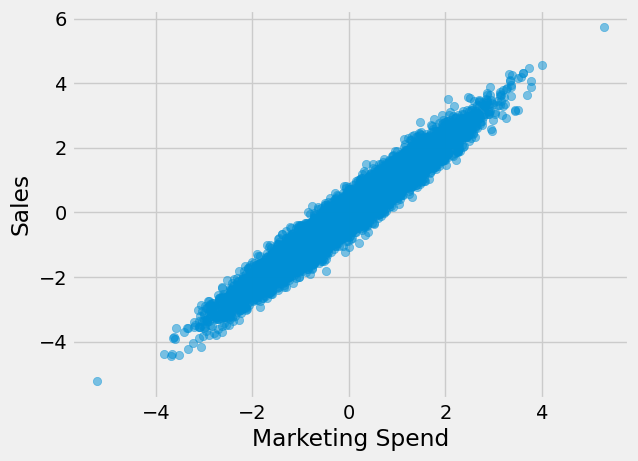

In [41]:
plt.scatter(df['MarketingSpend'], df['Sales'], alpha=.5)
plt.xlabel('Marketing Spend')
plt.ylabel('Sales')
plt.show()

## Naive Effect

In [51]:
# Naive effect
naive = stats.linregress(marketing_spend, sales)


print(f'Estimate of naive effect (linear regression): {naive.slope}')

Estimate of naive effect (linear regression): 1.1151967224080097


In [58]:
# CIs
tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
ts = tinv(0.05, len(marketing_spend)-2)

np.array(
    [
        naive.slope - ts*naive.stderr,
        naive.slope + ts*naive.stderr
    ]
)

array([1.10995276, 1.12044069])

## Build a Causal Model

In [42]:
# Build a causal graph
graph = nx.DiGraph()

edges = [
    ("PurchasingPower", "MarketingSpend"),
    ("PurchasingPower", "Sales"),
    ("Seasonality", "MarketingSpend"),
    ("Seasonality", "Sales"),
    ("Price", "MarketingSpend"),
    ("Price", "Sales"),
    ("MarketingSpend", "Sales"),
]

graph.add_edges_from(edges)

In [43]:
# With graph
model = CausalModel(
    data=df,
    treatment='MarketingSpend',
    outcome='Sales',
    graph=graph
)

<Figure size 100x100 with 0 Axes>

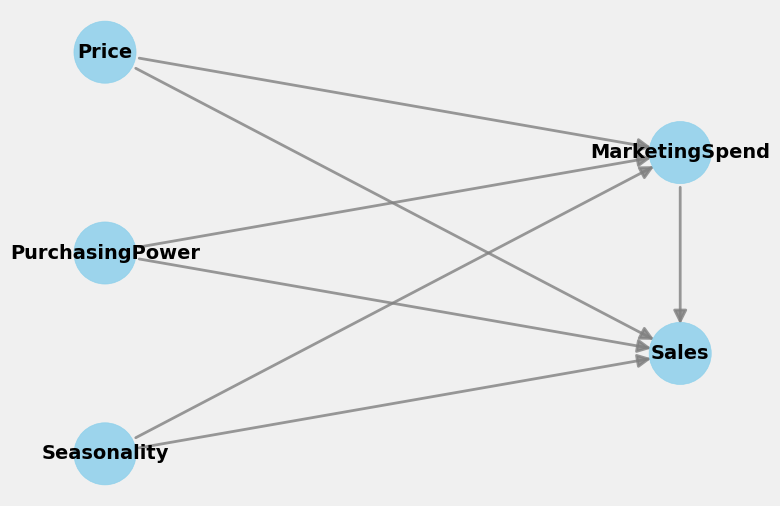

In [44]:
plt.figure(figsize=(1, 1))
model.view_model()
plt.show()

## Causal (Adjusted) Effect

In [45]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                    
─────────────────(E[Sales|Seasonality,Price,PurchasingPower])
d[MarketingSpend]                                            
Estimand assumption 1, Unconfoundedness: If U→{MarketingSpend} and U→Sales then P(Sales|MarketingSpend,Seasonality,Price,PurchasingPower,U) = P(Sales|MarketingSpend,Seasonality,Price,PurchasingPower)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [46]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression',
    target_units='ate'
)

print(f'Estimate of causal effect (linear regression): {estimate.value}')

Estimate of causal effect (linear regression): -0.005423771197626288


C:\Users\aleks\anaconda3\envs\causal_book_py312\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [47]:
estimate.get_confidence_intervals()

array([[-0.02487074,  0.0140232 ]])